<a href="https://colab.research.google.com/github/haidershoaib98/Link-Prediction-Machine-Learning-Project/blob/main/GraphSageProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/link-prediction/graphsage-link-prediction.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/link-prediction/graphsage-link-prediction.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

# Imports and setup

In [ ]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 435 kB 5.3 MB/s 
     |████████████████████████████████| 482 kB 34.6 MB/s 
     |████████████████████████████████| 41 kB 538 kB/s 


In [ ]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [ ]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, HinSAGE, link_classification

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

# CiteSeer

In [ ]:
# Import Python libraries
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sp
import pandas as pd
import json
import random
from stellargraph import StellarGraph

In [ ]:
dataset = datasets.CiteSeer()
display(HTML(dataset.description))
G, _ = dataset.load(largest_connected_component_only=False)

In [ ]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 3312, Edges: 4715

 Node types:
  paper: [3312]
    Features: float32 vector, length 3703
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [4715]
        Weights: all 1 (default)
        Features: none


From the original graph G, extract a randomly sampled subset of test edges (true and false citation links) and the reduced graph G_test with the positive test edges removed:

In [ ]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 471 positive and 471 negative edges. **


In [ ]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 424 positive and 424 negative edges. **


In [ ]:
print(len(edge_ids_train))

848


In [ ]:
print(G_train.info())

StellarGraph: Undirected multigraph
 Nodes: 3312, Edges: 3820

 Node types:
  paper: [3312]
    Features: float32 vector, length 3703
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [3820]
        Weights: all 1 (default)
        Features: none


In [ ]:
print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 3312, Edges: 4244

 Node types:
  paper: [3312]
    Features: float32 vector, length 3703
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [4244]
        Weights: all 1 (default)
        Features: none


In [ ]:
e = G_test.edges(include_edge_type=False, include_edge_weight=False, use_ilocs=False)

In [ ]:
print(len(set(e)))

4196


In [ ]:
import networkx as nx

In [ ]:
test_nx = nx.Graph()
test_nx.add_nodes_from(G_test.nodes())
test_nx.add_edges_from(G_test.edges())
print(test_nx.edges())

[('100157', '100157'), ('100157', '364207'), ('100157', '38848'), ('100157', 'bradshaw97introduction'), ('100157', 'bylund99coordinating'), ('100157', 'dix01metaagent'), ('100157', 'gray99finding'), ('100157', 'labrou01standardizing'), ('100157', 'labrou99agent'), ('100157', 'nodine98overview'), ('100157', 'nodine99active'), ('100157', 'wagner97artificial'), ('100598', '455651'), ('100598', 'marquez00machine'), ('100598', 'punyakanok01use'), ('105684', 'weiss00building'), ('11099', 'itskevitch01automatic'), ('114091', 'groh99automated'), ('11510', '23381'), ('11510', '29551'), ('11510', '3602'), ('11510', 'heintz00robosoc'), ('11510', 'veloso99cmunited'), ('11510', 'stone98layered'), ('115971', '295535'), ('115971', 'kumar00adaptive'), ('115971', '187087'), ('115971', 'klein91supporting'), ('117999', 'brin98anatomy'), ('117999', 'howe97savvysearch'), ('117999', 'zaiane98discovering'), ('117999', 'zamir98web'), ('120432', 'sadri99computational'), ('120432', 'sakama99updating'), ('126894

In [ ]:
G_full = nx.Graph()
G_full.add_nodes_from(G.nodes())
G_full.add_edges_from(G.edges())
print(G_full.edges())

[('100157', '100157'), ('100157', '364207'), ('100157', '38848'), ('100157', 'bradshaw97introduction'), ('100157', 'bylund99coordinating'), ('100157', 'dix01metaagent'), ('100157', 'gray99finding'), ('100157', 'labrou01standardizing'), ('100157', 'labrou99agent'), ('100157', 'nodine98overview'), ('100157', 'nodine99active'), ('100157', 'wagner97artificial'), ('100598', '455651'), ('100598', 'marquez00machine'), ('100598', 'punyakanok01use'), ('105684', 'weiss00building'), ('11099', 'itskevitch01automatic'), ('114091', 'groh99automated'), ('11510', '23381'), ('11510', '29551'), ('11510', '3602'), ('11510', 'heintz00robosoc'), ('11510', 'veloso99cmunited'), ('11510', 'stone98layered'), ('115971', '295535'), ('115971', 'kumar00adaptive'), ('115971', '187087'), ('115971', 'klein91supporting'), ('117999', 'brin98anatomy'), ('117999', 'howe97savvysearch'), ('117999', 'zaiane98discovering'), ('117999', 'zamir98web'), ('120432', 'sadri99computational'), ('120432', 'sakama99updating'), ('126894

In [ ]:
adj = nx.adjacency_matrix(test_nx)
fof = adj.T.dot(adj)
test_dict = {index: value for index, value in enumerate(list(test_nx))}
fof_graph = nx.convert_matrix.from_scipy_sparse_matrix(fof)
fof_graph = nx.relabel_nodes(fof_graph, test_dict)
fof_graph.remove_edges_from(nx.selfloop_edges(fof_graph))
fof_graph.remove_edges_from(test_nx.edges)

In [ ]:
print(fof_graph)
fof_edges = list(fof_graph.edges)
print(fof_edges)

Graph with 3312 nodes and 15119 edges
[('100157', 'martelli99specification'), ('100157', 'bozzano99logic'), ('100157', 'fikes99distributed'), ('100157', '87014'), ('100157', 'zini01caselp'), ('100157', 'tveit01survey'), ('100157', 'silverman01more'), ('100157', 'joseph01why'), ('100157', 'dragoni00mental'), ('100157', 'distefano01coordinating'), ('100157', 'devedzic01knowledge'), ('100157', '535300'), ('100157', '443686'), ('100157', '63694'), ('100157', '32521'), ('100157', 'sadri99computational'), ('100157', 'brass99equivalence'), ('100157', 'brass99computation'), ('100157', 'arisha99impact'), ('100157', '4664'), ('100157', 'waern98concall'), ('100157', 'lisetti00automatic'), ('100157', 'kurki99agents'), ('100157', 'helmer01software'), ('100157', 'helmer01automated'), ('100157', '412941'), ('100157', 'wache01ontologybased'), ('100157', 'timm01from'), ('100157', 'luo02hybrid'), ('100598', 'mccallum00maximum'), ('100598', '294238'), ('100598', 'schapire98boosting'), ('100598', 'roth98l

In [ ]:
jaccard_coef = nx.link_prediction.jaccard_coefficient(test_nx, fof_edges)
jaccard_list = np.fromiter(jaccard_coef, dtype='U16,U16,f8')

In [ ]:
jaccard_sort = sorted(jaccard_list, key=lambda x:x[2])
print(jaccard_sort[:10:-1])
jaccard_sort = [(x, y) for (x, y, z) in jaccard_sort]
jaccard_sort[:-10:-1]

[('wang99critical', 'wang99negation', 1.), ('schuster98neural', 'smola01regulariz', 1.), ('prentzas01webbas', 'prentzas02webbas', 1.), ('pinheirodasilva0', 'pinheirodasilva0', 1.), ('olson00probabili', 'olson99subpixel', 1.), ('muscettola98refo', 'simmons00first', 1.), ('munro99footprint', 'wang01supporting', 1.), ('meeden98trend', 'parker98adaptive', 1.), ('magoulas01hybrid', 'plagianakos01tum', 1.), ('liu98logical', 'liu99partial', 1.), ('liu01rulebased', 'liu98logical', 1.), ('liu01rulebased', 'liu99partial', 1.), ('levison96connect', 'schweiss99archit', 1.), ('layzell98new', 'miller99genetic', 1.), ('kruegel02distrib', 'pouzol01from', 1.), ('koster99normaliz', 'lin01indexing', 1.), ('konrad98model', 'konrad99model', 1.), ('karkanis00image', 'sutton93online', 1.), ('jonsson00plannin', 'muscettola98refo', 1.), ('jonsson00plannin', 'simmons00first', 1.), ('jalali-sohi01int', 'jalali-sohi01mul', 1.), ('itti99comparison', 'itti99learning', 1.), ('ian99kea', 'turney99learning', 1.), ('hu

[('wang99critical', 'wang99negation'),
 ('schuster98neural', 'smola01regulariz'),
 ('prentzas01webbas', 'prentzas02webbas'),
 ('pinheirodasilva0', 'pinheirodasilva0'),
 ('olson00probabili', 'olson99subpixel'),
 ('muscettola98refo', 'simmons00first'),
 ('munro99footprint', 'wang01supporting'),
 ('meeden98trend', 'parker98adaptive'),
 ('magoulas01hybrid', 'plagianakos01tum')]

In [ ]:
preferential_attach = nx.link_prediction.preferential_attachment(test_nx, fof_edges)
preferential_list = np.fromiter(preferential_attach, dtype='U16,U16,f8')
preferential_sort = sorted(preferential_list, key=lambda x:x[2])
preferential_sort = [(x, y) for (x, y, z) in preferential_sort]

In [ ]:
adamic_adar =  nx.link_prediction.adamic_adar_index(test_nx, fof_edges)
adamic_list = np.fromiter(adamic_adar, dtype='U16,U16,f8')
adamic_sort = sorted(adamic_list, key=lambda x:x[2])
adamic_sort = [(x, y) for (x, y, z) in adamic_sort]

In [ ]:
temp_graph = nx.Graph(test_nx)
nx.set_node_attributes(temp_graph, 0, 'community')

In [ ]:
common_neighbor = nx.link_prediction.cn_soundarajan_hopcroft(temp_graph, fof_edges)
common_neighbor_list = np.fromiter(common_neighbor, dtype='U16,U16,f8')
common_neighbor_list = sorted(common_neighbor_list, key=lambda x:x[2])
common_neighbor_sorted = [(x, y) for (x, y, z) in common_neighbor_list]

In [ ]:
T = nx.Graph()
for edge in G_full.edges():
  if not test_nx.has_edge(edge[0], edge[1]):
    T.add_edge(edge[0], edge[1])
print(len(list(T.edges)))

464


# GraphSAGE

In [ ]:
batch_size = 30
epochs = 20

Specify the sizes of 1- and 2-hop neighbour samples for GraphSAGE. Note that the length of `num_samples` list defines the number of layers/iterations in the GraphSAGE model. In this example, we are defining a 2-layer GraphSAGE model:

In [ ]:
num_samples = [20, 10]

For training we create a generator on the `G_train` graph, and make an iterator over the training links using the generator's `flow()` method. The `shuffle=True` argument is given to the `flow` method to improve training.

In [ ]:
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples)
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)

At test time we use the `G_test` graph and don't specify the `shuffle` argument (it defaults to `False`).

In [ ]:
test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

In [ ]:
layer_sizes = [50, 50]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes ,generator=train_gen, bias=True, dropout=0.3
)

In [ ]:
# Build the model and expose input and output sockets of graphsage model
# for link prediction
x_inp, x_out = graphsage.in_out_tensors()

In [ ]:
print((x_out[0]))

KerasTensor(type_spec=TensorSpec(shape=(None, 50), dtype=tf.float32, name=None), name='lambda/l2_normalize:0', description="created by layer 'lambda'")


In [ ]:
prediction = link_classification(
    output_dim=1, output_act="relu", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [ ]:
print(prediction)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='reshape_8/Reshape:0', description="created by layer 'reshape_8'")


Input to Keras model and use cross-entropy loss

In [ ]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-4),
    loss=keras.losses.binary_crossentropy,
    metrics=["acc"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

32/32 [==============================] - 8s 252ms/step - loss: 0.5350 - acc: 0.7548

Train Set Metrics of the initial (untrained) model:
	loss: 0.5555
	acc: 0.7264

Test Set Metrics of the initial (untrained) model:
	loss: 0.5350
	acc: 0.7548


Train the model:

In [ ]:
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow, verbose=2)

Epoch 1/20
29/29 - 18s - loss: 0.6571 - acc: 0.6486 - val_loss: 0.5210 - val_acc: 0.7537 - 18s/epoch - 613ms/step
Epoch 2/20
29/29 - 15s - loss: 0.5794 - acc: 0.7040 - val_loss: 0.5154 - val_acc: 0.7601 - 15s/epoch - 528ms/step
Epoch 3/20
29/29 - 15s - loss: 0.5570 - acc: 0.7441 - val_loss: 0.5059 - val_acc: 0.7548 - 15s/epoch - 527ms/step
Epoch 4/20
29/29 - 15s - loss: 0.5317 - acc: 0.7677 - val_loss: 0.4977 - val_acc: 0.7548 - 15s/epoch - 516ms/step
Epoch 5/20
29/29 - 15s - loss: 0.4999 - acc: 0.8267 - val_loss: 0.4819 - val_acc: 0.7813 - 15s/epoch - 504ms/step
Epoch 6/20
29/29 - 15s - loss: 0.4641 - acc: 0.8384 - val_loss: 0.4699 - val_acc: 0.7898 - 15s/epoch - 515ms/step
Epoch 7/20
29/29 - 15s - loss: 0.4499 - acc: 0.8502 - val_loss: 0.4543 - val_acc: 0.8036 - 15s/epoch - 512ms/step
Epoch 8/20
29/29 - 15s - loss: 0.4017 - acc: 0.8903 - val_loss: 0.4415 - val_acc: 0.8121 - 15s/epoch - 532ms/step
Epoch 9/20
29/29 - 15s - loss: 0.4119 - acc: 0.8868 - val_loss: 0.4239 - val_acc: 0.8270

Plot the training history:

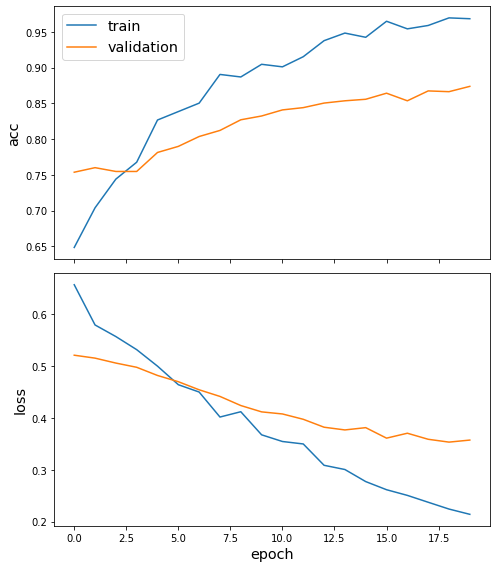

In [ ]:
sg.utils.plot_history(history)

Evaluate the trained model on test citation links:

In [ ]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

32/32 [==============================] - 8s 250ms/step - loss: 0.3484 - acc: 0.8747

Train Set Metrics of the trained model:
	loss: 0.0902
	acc: 0.9941

Test Set Metrics of the trained model:
	loss: 0.3484
	acc: 0.8747


# Link Prediction

In [ ]:
print(len(set(list(T.edges())) & set(jaccard_sort[:len(list(T.edges())):-1])))
print(len(set(list(T.edges())) & set(jaccard_sort[:len(list(T.edges())):-1]))/len(list(T.edges())))

print(len(set(list(T.edges())) & set(preferential_sort[:len(list(T.edges())):-1])))
print(len(set(list(T.edges())) & set(preferential_sort[:len(list(T.edges())):-1]))/len(list(T.edges())))

print(len(set(list(T.edges())) & set(adamic_sort[:len(list(T.edges())):-1])))
print(len(set(list(T.edges())) & set(adamic_sort[:len(list(T.edges())):-1]))/len(list(T.edges())))

print(len(set(list(T.edges())) & set(common_neighbor_sorted[:len(list(T.edges())):-1])))
print(len(set(list(T.edges())) & set(common_neighbor_sorted[:len(list(T.edges())):-1]))/len(list(T.edges())))

85
0.185589519650655
91
0.19868995633187772
92
0.20087336244541484
92
0.20087336244541484


<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/link-prediction/graphsage-link-prediction.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/link-prediction/graphsage-link-prediction.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>